In [1]:
import graph_tool.all as gt
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import datetime

In [2]:
class FindID(object):
    def __init__(self):
        from pymongo import MongoClient
        client = MongoClient('localhost', 27017)
        self.db = client['csci5352']
        pass
    

    def get_bids_per_state(self, state_name):
        col = self.db.restaurants.find({
            "state": state_name
        }, {
            "_id": 0, 
            "bid": 1 
        })
        return col
    
    def get_edges_per_bid(self, bid, full=False): 
        if not full:
            _full = 0
        else:
            _full = 1
        
        col = self.db.edges.find({
            "bid": bid,
        }, {
            "_id": 0,
            "bid": 1,
            "uid": 1, 
            "stars": _full,
            "useful": _full, 
            "funny": _full,
            "cool": _full
        })
        return col
    
    def get_g_per_state(self, state_name):
        edgelist = []
        g = gt.Graph()
        g.set_directed(False)
        
        col = self.get_bids_per_state(state_name)
        col = list(col)
        for idx, c in enumerate(col):
            edges = list(fid.get_edges_per_bid(c["bid"], full=True))
            edgelist += edges

        uid2index, bid2index = self.build_indices_from_edgelist(edgelist)
          
        # initiate edge properties
        g.ep["stars"] = g.new_ep("int")
        g.ep["useful"] = g.new_ep("int")
        g.ep["funny"] = g.new_ep("int")
        g.ep["cool"] = g.new_ep("int")
        
        g.vp["uid"] = g.new_vp("string")
        g.vp["bid"] = g.new_vp("string")
        
        for edge in edgelist:
            s = uid2index[edge["uid"]]
            t = bid2index[edge["bid"]]
            g.add_edge(s, t)
            
            g.ep["stars"][s, t] = edge["stars"]
            g.ep["useful"][s, t] = edge["useful"]
            g.ep["funny"][s, t] = edge["funny"]
            g.ep["cool"][s, t] = edge["cool"]
            
            g.vp["uid"][s] = edge["uid"]
            g.vp["bid"][t] = edge["bid"]
            
        g.vp["kind"] = g.new_vp("int")  # both
        g.vp["location"] = g.new_vp("string")  # both
        g.vp["review_count"] = g.new_vp("int")  # both
        g.vp["average_stars"] = g.new_vp("float")  # both
        g.vp["friends"] = g.new_vp("int")  # only for users
        g.vp["fans"] = g.new_vp("int")  # only for users

        kind = [0] * len(uid2index) + [1] * len(bid2index)
        for ind, v in enumerate(g.vertices()):
            g.vp["kind"][v] = kind[ind]
            if kind[ind] == 0:  # user
                col = self.get_user_info_per_uid(g.vp["uid"][v])
                g.vp["location"][v] = col["location"]
                g.vp["review_count"][v] = col["review_count"]
                g.vp["friends"][v] = col["friends"]
                g.vp["fans"][v] = col["fans"]
                g.vp["average_stars"][v] = col["average_stars"]
                
            else:  # restaurant
                col = self.get_restaurant_info_per_bid(g.vp["bid"][v])
                g.vp["location"][v] = col["city"] + ", " + col["state"]
                g.vp["average_stars"][v] = col["stars"]
                g.vp["review_count"][v] = col["review_count"]
        return g

    def get_user_info_per_uid(self, uid):
        col = self.db.users.find_one({
            "uid": uid,
        }, {
            "_id": 0,
            "location": 1,
            "review_count": 1, 
            "friends": 1,
            "fans": 1,
            "average_stars": 1
        })
        return col

    def get_restaurant_info_per_bid(self, bid):
        col = self.db.restaurants.find_one({
            "bid": bid,
        }, {
            "_id": 0,
            "stars": 1, 
            "review_count": 1,
            "city": 1, 
            "state": 1
        })             
        return col
    
    def build_indices_from_edgelist(self, edgelist):
        uid = set()
        bid = set()
        for edge in edgelist:
            uid.add(edge["uid"])
            bid.add(edge["bid"])

        uid2index = OrderedDict()
        bid2index = OrderedDict()
        for u_ind, _uid in enumerate(uid):
            uid2index[_uid] = u_ind

        for b_ind, _bid in enumerate(bid):
            bid2index[_bid] = b_ind + u_ind + 1
        
        return uid2index, bid2index
    
    
    def do_inference(self, g):
        clabel =g.vp['kind']
        state_args = {'clabel': clabel, 'pclabel': clabel}
        state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, state_args=state_args)
        return state
    
    def do_weighted_inference(self, g):
        clabel =g.vp['kind']
        state_args = {'clabel': clabel, 'pclabel': clabel}
        state_args["eweight"] = g.ep["stars"]
        state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, state_args=state_args)
        return state    

In [3]:
fid = FindID()

In [15]:
%%time
g = fid.get_g_per_state("OH")

CPU times: user 8min 38s, sys: 4.53 s, total: 8min 42s
Wall time: 9min 16s


In [4]:
g = gt.load_graph("./OH.gt")

In [16]:
g

<Graph object, undirected, with 53381 vertices and 153924 edges at 0x184db81d0>

In [14]:
g.list_properties()

average_stars  (vertex)  (type: double)
bid            (vertex)  (type: string)
fans           (vertex)  (type: int32_t)
friends        (vertex)  (type: int32_t)
kind           (vertex)  (type: int32_t)
location       (vertex)  (type: string)
partition      (vertex)  (type: int32_t)
partition_w    (vertex)  (type: int32_t)
review_count   (vertex)  (type: int32_t)
uid            (vertex)  (type: string)
cool           (edge)    (type: int32_t)
funny          (edge)    (type: int32_t)
stars          (edge)    (type: int32_t)
useful         (edge)    (type: int32_t)


In [17]:
state

<NestedBlockState object, with base <BlockState object with 100 blocks (100 nonempty), degree-corrected, for graph <Graph object, undirected, with 53381 vertices and 153924 edges at 0x1312675c0>, at 0x1655cad68>, and 5 levels of sizes [(53381, 100), (100, 27), (27, 7), (7, 2), (2, 1)] at 0x131292e80>

In [12]:
# state = fid.do_inference(g)
# print("done inference")
nested_state = fid.do_weighted_inference(g)
print("done weighted inference")
g.vp["partition"] = state.levels[0].b
g.vp["partition_w"] = nested_state.levels[0].b
g.save("OH" + "_network.gml")

done weighted inference


In [9]:
g.save("NC" + "_network.gml")

In [11]:
g.vp["shape"] = g.new_vertex_property("string")
g.vp["fill_color"] = g.new_vertex_property("string")

for idx, v in enumerate(g.vertices()):
#     g.vp["fill_color"][v] = "#111111"
    if g.vp["kind"][v] == 0:
        g.vp["shape"][v] = "double_circle"
        g.vp["fill_color"][v] = "#0074D9"
    else:
        g.vp["shape"][v] = "double_circle"
        g.vp["fill_color"][v] = "#FF4136"



In [7]:
%%time
state = fid.do_inference(g)

CPU times: user 26min 38s, sys: 1min 6s, total: 27min 44s
Wall time: 19min 42s


In [13]:
g.save("OH_network.gml")

In [ ]:
g

In [9]:
%%time
nested_state = fid.do_weighted_inference(g)

CPU times: user 48min 48s, sys: 2min 13s, total: 51min 1s
Wall time: 30min 9s


In [ ]:
for s in ["NC"]:
    g = fid.get_g_per_state(s)
    print("graph loaded")
    state = fid.do_inference(g)
    print("done inference")
    nested_state = fid.do_weighted_inference(g)
    print("done weighted inference")
    g.vp["partition"] = state.levels[0].b
    g.vp["partition_w"] = nested_state.levels[0].b
    g.save(s + "_network.gml")
              

In [38]:
state

<NestedBlockState object, with base <BlockState object with 96 blocks (96 nonempty), degree-corrected, for graph <Graph object, undirected, with 61129 vertices and 202934 edges at 0x1372052b0>, at 0x1370b6c88>, and 6 levels of sizes [(61129, 96), (96, 34), (34, 14), (14, 7), (7, 2), (2, 1)] at 0x151a0b828>

In [39]:
state.entropy() / len(g.get_edges())

6.928384823614599

In [27]:
nested_state

<NestedBlockState object, with base <BlockState object with 5380 blocks (5380 nonempty), degree-corrected, for graph <Graph object, undirected, with 69686 vertices and 247932 edges at 0x137205470>, at 0x137205128>, and 6 levels of sizes [(69686, 5380), (5380, 1502), (1502, 697), (697, 101), (101, 2), (2, 1)] at 0x152033358>

In [40]:
nested_state.entropy() / len(g.get_edges())

15.796536491870544

In [12]:
g.list_properties()

average_stars  (vertex)  (type: double)
bid            (vertex)  (type: string)
fans           (vertex)  (type: int32_t)
friends        (vertex)  (type: int32_t)
kind           (vertex)  (type: int32_t)
location       (vertex)  (type: string)
partition      (vertex)  (type: int32_t)
partition_w    (vertex)  (type: int32_t)
review_count   (vertex)  (type: int32_t)
uid            (vertex)  (type: string)
cool           (edge)    (type: int32_t)
funny          (edge)    (type: int32_t)
stars          (edge)    (type: int32_t)
useful         (edge)    (type: int32_t)


In [11]:
g.vp["partition"] = state.levels[0].b
g.vp["partition_w"] = nested_state.levels[0].b

In [72]:
g = gt.Graph()
edgelist = []


uid = 0

for idx, c in enumerate(col):
    edges = list(fid.get_edges_per_bid(c["bid"]))
    edgelist += edges

    #     print(edges)
    #     print('---')

In [90]:
uid = set()
bid = set()
for edge in edgelist:
    uid.add(edge["uid"])
    bid.add(edge["bid"])
    
uid2index = OrderedDict()
bid2index = OrderedDict()
for u_ind, _uid in enumerate(uid):
    uid2index[_uid] = u_ind
    
for b_ind, _bid in enumerate(bid):
    bid2index[_bid] = b_ind + u_ind + 1

In [94]:
g.set_directed(False)
for edge in edgelist:
    g.add_edge(uid2index[edge["uid"]], bid2index[edge["bid"]])

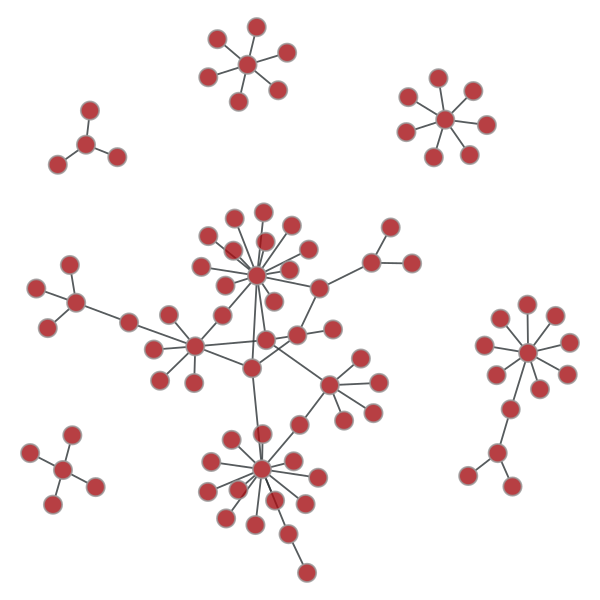

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137b97358, at 0x1384c6208>

In [96]:
gt.graph_draw(g)